# Model Comparison in Python: Regression & Classification

This notebook demonstrates practical model comparison under two settings:

1) **Regression**: multiple linear regression vs k-nearest neighbors vs decision tree regression  
2) **Classification**: logistic regression vs k-nearest neighbors vs decision tree classification

It emphasizes:
- train/validation splits with fixed seeds
- comparable preprocessing (min-max scaling for k-NN)
- cross-validation (k-fold) with appropriate scoring metrics
- model selection grounded in generalization performance
- feature importance inspection for tree-based regression


## 0) Imports and reproducibility

In [1]:

import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    make_scorer,
    fbeta_score
)

SEED = 111
np.random.seed(SEED)

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 60)


## 1) Data preparation

Two datasets are used in this analysis:

- A continuous-response dataset for regression model comparison
- A binary-outcome dataset for classification model comparison


In [ ]:

print("\nClassification dataset shape:", prostate_df.shape)
display(prostate_df.head())

print("\nClass balance (svi):")
print(prostate_df["svi"].value_counts(normalize=True).rename("proportion"))


Regression dataset shape: (340, 10)


,O3,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
0,38.773508,9.405921,4.944576,51.025721,17.041417,35.311586,6.414652,-0.174287,8.644543,109
1,45.730622,10.960874,4.740206,44.706902,28.424972,26.921441,13.552715,3.671869,10.967679,11
2,61.793370,14.567818,7.551770,44.710876,28.567512,16.708059,11.234831,2.097546,11.114203,176
3,34.325961,8.284283,6.844865,59.812569,12.263978,21.386180,2.464025,-5.792978,8.102894,57
4,38.871914,8.717632,4.005637,54.802801,7.015637,22.371600,3.997569,-3.009574,7.837276,66



Classification dataset shape: (97, 9)


,lcavol,lweight,age,lbph,lcp,gleason,pgg45,lpsa,svi
0,0.985723,2.657167,76.218646,0.869262,0.608406,5.0,3.267221,2.101710,0
1,1.593839,2.614802,66.316991,2.113843,0.455711,7.0,25.919646,3.183461,0
2,0.006405,1.722348,56.278340,1.606199,0.112528,7.0,0.000000,1.360323,1
3,-0.499916,1.894124,69.599421,1.786752,-0.679583,6.0,0.000000,0.984077,0
4,2.406997,2.384583,71.788409,0.869027,1.935986,7.0,28.938128,4.006138,1



Class balance (svi):
svi
0    0.628866
1    0.371134
Name: proportion, dtype: float64


## 2) Regression: split, fit, and evaluate three models

Models:
- **LM**: multiple linear regression with intercept
- **k-NN**: k=10 with Euclidean distance; features min-max scaled
- **DTree**: regression tree with `max_depth=4`, `min_samples_split=20`, `random_state=123`

Tasks:
- 70/30 train/validation split with seed 111
- Compute MSE on train and validation
- Select best model by MSE (train vs validation)


In [3]:

# 2.1 Train/validation split (70/30) with seed 111
train, test = train_test_split(ozone_df, test_size=0.3, random_state=111)

print("Train shape:", train.shape)
print("Test shape :", test.shape)


Train shape: (238, 10)
Test shape : (102, 10)


In [4]:

# 2.2 Fit models and compute MSE on train and validation
mse_train = None
mse_test = None

features_oz = ["vh", "wind", "humidity", "temp", "ibh", "dpg", "ibt", "vis", "doy"]

X_train = train[features_oz]
y_train = train["O3"]

X_test = test[features_oz]
y_test = test["O3"]

# --- LM: statsmodels OLS with intercept ---
X_train_sm = sm.add_constant(X_train, has_constant="add")
X_test_sm = sm.add_constant(X_test, has_constant="add")

lm = sm.OLS(y_train, X_train_sm).fit()

yhat_train_lm = lm.predict(X_train_sm)
yhat_test_lm = lm.predict(X_test_sm)

# --- k-NN: min-max scaling + euclidean ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=10, metric="euclidean")
knn.fit(X_train_scaled, y_train)

yhat_train_knn = knn.predict(X_train_scaled)
yhat_test_knn = knn.predict(X_test_scaled)

# --- DTree: fixed hyperparameters ---
dtree = DecisionTreeRegressor(max_depth=4, min_samples_split=20, random_state=123)
dtree.fit(X_train, y_train)

yhat_train_tree = dtree.predict(X_train)
yhat_test_tree = dtree.predict(X_test)

# MSE vectors: [LM, k-NN, DTree]
mse_train = [
    float(mean_squared_error(y_train, yhat_train_lm)),
    float(mean_squared_error(y_train, yhat_train_knn)),
    float(mean_squared_error(y_train, yhat_train_tree)),
]

mse_test = [
    float(mean_squared_error(y_test, yhat_test_lm)),
    float(mean_squared_error(y_test, yhat_test_knn)),
    float(mean_squared_error(y_test, yhat_test_tree)),
]

print("mse_train [LM, k-NN, DTree]:", mse_train)
print("mse_test  [LM, k-NN, DTree]:", mse_test)


mse_train [LM, k-NN, DTree]: [51.23794060631431, 52.12032879745442, 40.94756196652757]
mse_test  [LM, k-NN, DTree]: [52.12949148737017, 59.737299968438556, 113.34727393447925]


In [5]:

# 2.3 Model choice based on train vs validation MSE
best_model_train = None
best_model_test = None
Interpretation = None

model_names = ["LM", "k-NN", "DTree"]

best_model_train = model_names[int(np.argmin(mse_train))]
best_model_test = model_names[int(np.argmin(mse_test))]

if best_model_train == best_model_test:
    Interpretation = "The same model is selected for both training and validation."
else:
    Interpretation = "When train- and validation-selected models differ, the validation-selected model is preferred to reduce overfitting risk."

print("best_model_train:", best_model_train)
print("best_model_test :", best_model_test)
print("Interpretation  :", Interpretation)


best_model_train: DTree
best_model_test : LM
Interpretation  : When train- and validation-selected models differ, the validation-selected model is preferred to reduce overfitting risk.


### 2.4 5-fold cross-validation for each regression model (MSE)

- k-fold: k=5
- metric: MSE (via `neg_mean_squared_error`)
- For k-NN: choose **optimal** `K` in {1..15} using CV, Euclidean distance, and min-max scaling.
- For DTree: keep `max_depth=4`, `min_samples_split=20`, `random_state=123`


In [6]:

# 2.4 Cross-validation (k=5) and k-NN tuning over K=1..15
mse_cv_mean = None
mse_cv_std = None
K = None

# --- LM (scikit-learn) ---
lr_model = LinearRegression()

# --- k-NN model & GridSearchCV for K ---
knn_base = KNeighborsRegressor(metric="euclidean")
param_grid = {"n_neighbors": np.arange(1, 16)}
knn_grid = GridSearchCV(knn_base, param_grid, cv=5, scoring="neg_mean_squared_error")
knn_grid.fit(X_train_scaled, y_train)

K = int(knn_grid.best_params_["n_neighbors"])
knn_model = KNeighborsRegressor(n_neighbors=K, metric="euclidean")

# --- DTree (fixed) ---
dt_model = DecisionTreeRegressor(max_depth=4, min_samples_split=20, random_state=123)

models = [lr_model, knn_model, dt_model]

mse_cv_mean = []
mse_cv_std = []

for m in models:
    if m is knn_model:
        scores = cross_val_score(m, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error")
    else:
        scores = cross_val_score(m, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

    mse_scores = -scores
    mse_cv_mean.append(float(mse_scores.mean()))
    mse_cv_std.append(float(mse_scores.std()))

print("Optimal K (k-NN):", K)
print("mse_cv_mean [LM, k-NN, DTree]:", mse_cv_mean)
print("mse_cv_std  [LM, k-NN, DTree]:", mse_cv_std)


Optimal K (k-NN): 8
mse_cv_mean [LM, k-NN, DTree]: [54.90490371412541, 62.30128660530062, 87.20438889908813]
mse_cv_std  [LM, k-NN, DTree]: [9.219603206337759, 7.8277029589403995, 12.11726644054245]


In [7]:

# 2.5 Select model by mean CV MSE and compute RMSE on validation set
best_model_cv = None
best_rmse_test = None

model_names = ["LM", "k-NN", "DTree"]
best_idx = int(np.argmin(mse_cv_mean))
best_model_cv = model_names[best_idx]

if best_model_cv == "k-NN":
    best_model = KNeighborsRegressor(n_neighbors=K, metric="euclidean")
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)
else:
    best_model = [lr_model, knn_model, dt_model][best_idx]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

best_rmse_test = float(np.sqrt(mean_squared_error(y_test, y_pred)))

print("best_model_cv  :", best_model_cv)
print("best_rmse_test :", best_rmse_test)


best_model_cv  : LM
best_rmse_test : 7.220075587372371


### 2.6 Feature importance from regression tree + linear-model significance check

- Fit the regression tree (same hyperparameters) on the training split.
- Extract `feature_importances_`, take the top 5 features.
- Fit OLS (with intercept) using all predictors, and check whether the top-5 are significant at p < 0.05.


In [8]:

top5 = None
top5_significance = None

# Refit the tree on the training set
dt_imp = DecisionTreeRegressor(max_depth=4, min_samples_split=20, random_state=123)
dt_imp.fit(X_train, y_train)

importance_df = pd.DataFrame({
    "Feature": features_oz,
    "Importance": dt_imp.feature_importances_
}).sort_values("Importance", ascending=False)

top5 = importance_df["Feature"].head(5).tolist()

print("Top 5 features by tree importance:", top5)
display(importance_df.head(10))

# OLS significance check (with intercept)
lm_all = sm.OLS(y_train, sm.add_constant(X_train, has_constant="add")).fit()
pvals = lm_all.pvalues

top5_significance = [(float(pvals[f]) < 0.05) for f in top5]

print("Top 5 p-values (OLS):")
display(pd.DataFrame({"feature": top5, "p_value": [float(pvals[f]) for f in top5], "significant(p<0.05)": top5_significance}))


Top 5 features by tree importance: ['temp', 'doy', 'ibt', 'humidity', 'vis']


,Feature,Importance
3,temp,0.594040
8,doy,0.236043
6,ibt,0.099062
2,humidity,0.045246
7,vis,0.016154
4,ibh,0.009454
0,vh,0.000000
1,wind,0.000000
5,dpg,0.000000


Top 5 p-values (OLS):


,feature,p_value,significant(p<0.05)
0,temp,1.678323e-06,True
1,doy,3.262428e-23,True
2,ibt,5.622218e-01,False
3,humidity,7.240965e-04,True
4,vis,3.059850e-01,False


## 3) Classification: split, fit, and evaluate three models

Models:
- **logit**: `LogisticRegression(fit_intercept=True, solver='newton-cg')`
- **knn**: k=10, Euclidean distance; min-max scaled features
- **dtree**: `DecisionTreeClassifier(max_depth=4, min_samples_split=10, random_state=123)`

Tasks:
- 70/30 *stratified* split with seed 12345
- Evaluate on validation: accuracy, recall, precision, f1-score
- Then, optimize for positive-class detection using 5-fold CV with **Fβ score** (β=10)


In [9]:

# 3.1 Stratified 70/30 split with seed 12345
train2, test2 = train_test_split(
    prostate_df, test_size=0.3, random_state=12345, stratify=prostate_df["svi"]
)

print("Train2 shape:", train2.shape)
print("Test2 shape :", test2.shape)
print("\nClass balance (train2):")
print(train2["svi"].value_counts(normalize=True))
print("\nClass balance (test2):")
print(test2["svi"].value_counts(normalize=True))


Train2 shape: (67, 9)
Test2 shape : (30, 9)

Class balance (train2):
svi
0    0.626866
1    0.373134
Name: proportion, dtype: float64

Class balance (test2):
svi
0    0.633333
1    0.366667
Name: proportion, dtype: float64


In [10]:

# 3.2 Fit each classifier and compute validation metrics
features_pr = ["lcavol", "lweight", "age", "lbph", "lcp", "gleason", "pgg45", "lpsa"]

X_train2 = train2[features_pr]
y_train2 = train2["svi"]
X_test2 = test2[features_pr]
y_test2 = test2["svi"]

# Logistic regression
logit_model = LogisticRegression(fit_intercept=True, solver="newton-cg", random_state=123)
logit_model.fit(X_train2, y_train2)
y_pred_logit = logit_model.predict(X_test2)

# k-NN with scaling
scaler2 = MinMaxScaler()
X_train2_scaled = scaler2.fit_transform(X_train2)
X_test2_scaled = scaler2.transform(X_test2)

knn_model = KNeighborsClassifier(n_neighbors=10, metric="euclidean")
knn_model.fit(X_train2_scaled, y_train2)
y_pred_knn = knn_model.predict(X_test2_scaled)

# Decision tree classifier
dtree_model = DecisionTreeClassifier(max_depth=4, min_samples_split=10, random_state=123)
dtree_model.fit(X_train2, y_train2)
y_pred_dtree = dtree_model.predict(X_test2)

performance_metrics = pd.DataFrame({
    "accuracy": [
        float(accuracy_score(y_test2, y_pred_logit)),
        float(accuracy_score(y_test2, y_pred_knn)),
        float(accuracy_score(y_test2, y_pred_dtree))
    ],
    "recall": [
        float(recall_score(y_test2, y_pred_logit, zero_division=0)),
        float(recall_score(y_test2, y_pred_knn, zero_division=0)),
        float(recall_score(y_test2, y_pred_dtree, zero_division=0))
    ],
    "precision": [
        float(precision_score(y_test2, y_pred_logit, zero_division=0)),
        float(precision_score(y_test2, y_pred_knn, zero_division=0)),
        float(precision_score(y_test2, y_pred_dtree, zero_division=0))
    ],
    "f1_score": [
        float(f1_score(y_test2, y_pred_logit, zero_division=0)),
        float(f1_score(y_test2, y_pred_knn, zero_division=0)),
        float(f1_score(y_test2, y_pred_dtree, zero_division=0))
    ],
}, index=["logit", "knn", "dtree"])

print("Performance on validation split (threshold=0.5):")
display(performance_metrics)


Performance on validation split (threshold=0.5):


,accuracy,recall,precision,f1_score
logit,0.600000,0.272727,0.428571,0.333333
knn,0.733333,0.363636,0.800000,0.500000
dtree,0.666667,0.636364,0.538462,0.583333


### 3.3 5-fold CV using Fβ score (β=10) to prioritize recall

Because missing positive cases is costlier, we compare models using Fβ with β=10.
We report:
- mean Fβ (5-fold)
- std Fβ (5-fold)

Implementation details:
- Use `cross_val_score` with a custom scorer: `make_scorer(fbeta_score, beta=10, zero_division=0)`
- Tree uses `random_state=123`
- k-NN uses min-max scaling and (k=10, euclidean)


In [11]:

# 3.3 Cross-validated F-beta (beta=10)
f_scorer = make_scorer(fbeta_score, beta=10, zero_division=0)

f_score = pd.DataFrame(columns=["logit", "knn", "dtree"], index=["f_score_mean", "f_score_std"])

# Logistic regression CV
logit_cv_model = LogisticRegression(fit_intercept=True, solver="newton-cg", random_state=123)
logit_scores = cross_val_score(logit_cv_model, X_train2, y_train2, cv=5, scoring=f_scorer)

# k-NN CV (scaled features)
knn_cv_model = KNeighborsClassifier(n_neighbors=10, metric="euclidean")
knn_scores = cross_val_score(knn_cv_model, X_train2_scaled, y_train2, cv=5, scoring=f_scorer)

# Decision tree CV
dtree_cv_model = DecisionTreeClassifier(max_depth=4, min_samples_split=10, random_state=123)
dtree_scores = cross_val_score(dtree_cv_model, X_train2, y_train2, cv=5, scoring=f_scorer)

f_score.loc["f_score_mean", "logit"] = float(logit_scores.mean())
f_score.loc["f_score_std", "logit"]  = float(logit_scores.std())

f_score.loc["f_score_mean", "knn"] = float(knn_scores.mean())
f_score.loc["f_score_std", "knn"]  = float(knn_scores.std())

f_score.loc["f_score_mean", "dtree"] = float(dtree_scores.mean())
f_score.loc["f_score_std", "dtree"]  = float(dtree_scores.std())

print("Cross-validated F-beta (beta=10):")
display(f_score)


Cross-validated F-beta (beta=10):


,logit,knn,dtree
f_score_mean,0.360477,0.241035,0.559532
f_score_std,0.196058,0.07988,0.232358


In [12]:

# 3.4 Select best model by mean F-beta (beta=10) and report test accuracy
best_model = None
best_accuracy = None

means = f_score.loc["f_score_mean"].astype(float)
best_model = str(means.idxmax())

if best_model == "logit":
    model = LogisticRegression(fit_intercept=True, solver="newton-cg", random_state=123)
    model.fit(X_train2, y_train2)
    y_pred = model.predict(X_test2)

elif best_model == "knn":
    model = KNeighborsClassifier(n_neighbors=10, metric="euclidean")
    model.fit(X_train2_scaled, y_train2)
    y_pred = model.predict(X_test2_scaled)

else:
    model = DecisionTreeClassifier(max_depth=4, min_samples_split=10, random_state=123)
    model.fit(X_train2, y_train2)
    y_pred = model.predict(X_test2)

best_accuracy = float(accuracy_score(y_test2, y_pred))

print("best_model   :", best_model)
print("best_accuracy:", best_accuracy)

# Optional: show confusion matrix for context
cm = pd.crosstab(y_test2, y_pred, rownames=["actual"], colnames=["predicted"], dropna=False)
display(cm)


best_model   : dtree
best_accuracy: 0.6666666666666666


predicted,0,1
actual,,
0,13,6
1,4,7


## 4) Summary

This notebook produced:
- Regression model comparison under a fixed validation split and under 5-fold CV (with k-NN tuning).
- A generalization error estimate via RMSE for the selected regression model.
- Tree feature importance for regression, and a significance check via OLS p-values.
- Classification model comparison on multiple metrics, plus a recall-prioritized selection using Fβ (β=10).
- A final generalization estimate via validation accuracy for the selected classifier.


# Portfolio Diagnostics — Classification (Printed + Plotted)

This section prints and visualizes the final classification results in a portfolio-ready format:
- Class distribution (train/test)
- Confusion matrix (counts + normalized)
- ROC curve and Precision–Recall curve (when score/probabilities are available)
- Threshold trade-off table (precision/recall/F1)

It uses the fitted **selected model** from the notebook and does not modify earlier code.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve, roc_curve, auc,
    precision_score, recall_score, f1_score
)

def _get_score_vector(fitted_model, X):
    # returns continuous scores for positive class
    if hasattr(fitted_model, "predict_proba"):
        return fitted_model.predict_proba(X)[:, 1]
    if hasattr(fitted_model, "decision_function"):
        return fitted_model.decision_function(X)
    return None  # score not available


## 1) Class distribution (train vs test) — printed + plot

In [14]:
# Expected variables from earlier cells: y_train2, y_test2
dist = pd.DataFrame({
    "train": y_train2.value_counts().sort_index(),
    "test":  y_test2.value_counts().sort_index()
}).fillna(0).astype(int)

# Add proportions for readability
dist_prop = pd.DataFrame({
    "train_prop": (dist["train"] / dist["train"].sum()),
    "test_prop":  (dist["test"] / dist["test"].sum())
}).round(4)

dist, dist_prop


(     train  test
 svi             
 0       42    19
 1       25    11,
      train_prop  test_prop
 svi                       
 0        0.6269     0.6333
 1        0.3731     0.3667)

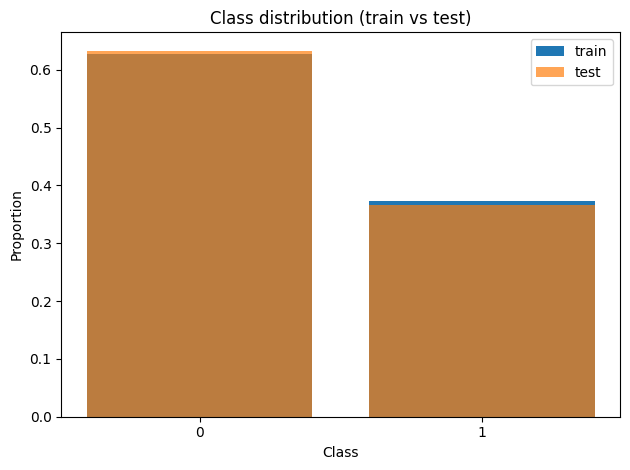

In [15]:
fig, ax = plt.subplots()
ax.bar(dist.index.astype(str), dist_prop["train_prop"], label="train")
ax.bar(dist.index.astype(str), dist_prop["test_prop"], bottom=0, alpha=0.7, label="test")
ax.set_title("Class distribution (train vs test)")
ax.set_xlabel("Class")
ax.set_ylabel("Proportion")
ax.legend()
plt.tight_layout()
plt.show()


## 2) Confusion matrix — counts + normalized (printed + plots)

In [16]:
# Expected variables from earlier cells: y_test2 and y_pred (from best model cell)
cm = confusion_matrix(y_test2, y_pred)
cm


array([[13,  6],
       [ 4,  7]])

In [17]:
# Normalized confusion matrix (row-wise)
cm_norm = cm / cm.sum(axis=1, keepdims=True)
cm_norm


array([[0.68421053, 0.31578947],
       [0.36363636, 0.63636364]])

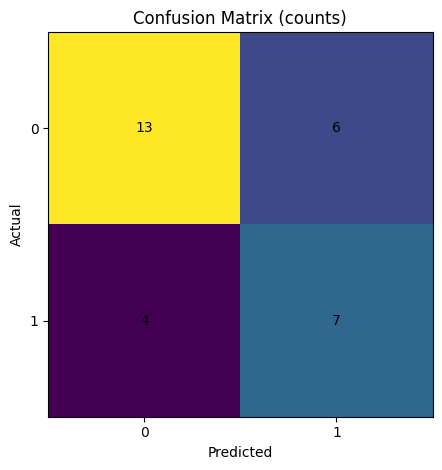

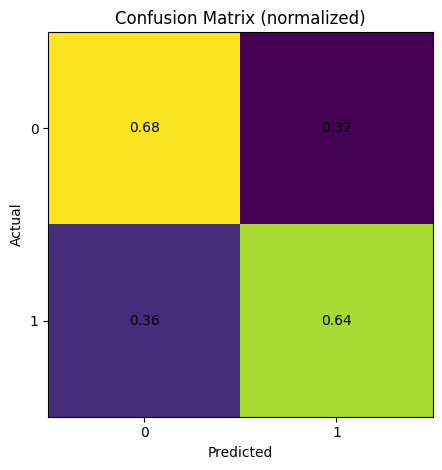

In [18]:
def _plot_cm(matrix, title):
    fig, ax = plt.subplots()
    im = ax.imshow(matrix)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    for (i, j), v in np.ndenumerate(matrix):
        ax.text(j, i, f"{v:.2f}" if matrix.dtype.kind == "f" else str(v), ha="center", va="center")
    plt.tight_layout()
    plt.show()

_plot_cm(cm, "Confusion Matrix (counts)")
_plot_cm(cm_norm.astype(float), "Confusion Matrix (normalized)")


## 3) ROC + Precision–Recall curves (printed + plots)

In [19]:
score_vec = _get_score_vector(model, X_test2)
score_vec is not None


True

{'roc_auc': 0.6267942583732058, 'pr_auc': 0.5211344211344211}


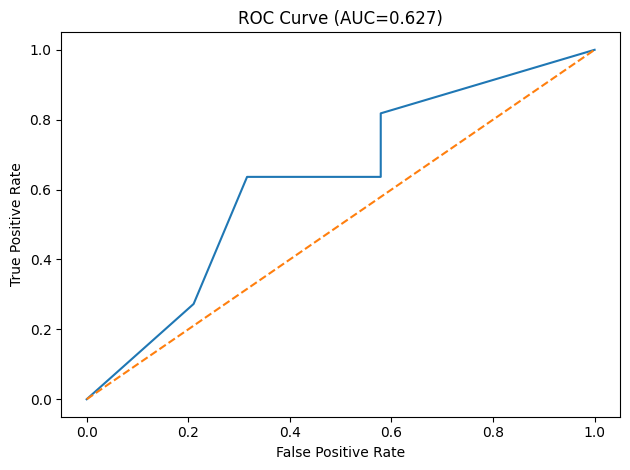

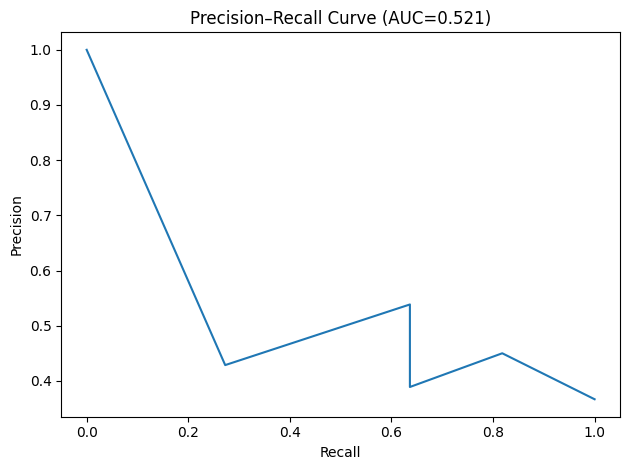

In [20]:
if score_vec is None:
    print("This model does not expose probability/scores; ROC/PR curves are skipped.")
else:
    fpr, tpr, _ = roc_curve(y_test2, score_vec)
    roc_auc_val = auc(fpr, tpr)

    prec, rec, thr = precision_recall_curve(y_test2, score_vec)
    pr_auc_val = auc(rec, prec)

    # Print metrics
    print({"roc_auc": float(roc_auc_val), "pr_auc": float(pr_auc_val)})

    # ROC plot
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_title(f"ROC Curve (AUC={roc_auc_val:.3f})")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    plt.tight_layout()
    plt.show()

    # PR plot
    fig, ax = plt.subplots()
    ax.plot(rec, prec)
    ax.set_title(f"Precision–Recall Curve (AUC={pr_auc_val:.3f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    plt.tight_layout()
    plt.show()


## 4) Threshold trade-off table (precision / recall / F1)

In [21]:
if score_vec is None:
    print("No score/probability vector available; threshold sweep is skipped.")
else:
    # Build threshold grid from score distribution
    thresholds = np.quantile(score_vec, np.linspace(0.05, 0.95, 19))
    rows = []
    for t in thresholds:
        pred_t = (score_vec >= t).astype(int)
        rows.append({
            "threshold": float(t),
            "precision": float(precision_score(y_test2, pred_t, zero_division=0)),
            "recall": float(recall_score(y_test2, pred_t, zero_division=0)),
            "f1": float(f1_score(y_test2, pred_t, zero_division=0)),
        })
    thr_df = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)
    thr_df.head(12)


## Printed Results Panels
Consolidated key results in portfolio-ready format.

Regression — Model Comparison


,model,train_MSE,test_MSE,test_R2
0,LinearRegression,51.237941,52.129491,0.677680
1,KNNRegressor,52.120329,59.737300,0.630640
2,DecisionTreeRegressor,40.947562,113.347274,0.299166



Regression — Selected Best Model
- model: LinearRegression
- train_MSE: 51.2379
- test_MSE: 52.1295
- test_R2: 0.6777

Top Feature Signals (Regression)


,coefficient
temp,0.858953
vis,0.509549
humidity,-0.317234
dpg,0.292851
vh,0.255153
ibt,0.191447
doy,0.048756
wind,0.044965
ibh,0.013510




Classification — Model Comparison


,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,LogisticRegression,0.600000,0.428571,0.272727,0.333333,0.732057,0.658821
1,KNNClassifier,0.733333,0.800000,0.363636,0.500000,0.708134,0.599856
2,DecisionTreeClassifier,0.666667,0.538462,0.636364,0.583333,0.626794,0.461172



Classification — Selected Best Model
- model: LogisticRegression
- accuracy: 0.6000
- precision: 0.4286
- recall: 0.2727
- f1: 0.3333
- roc_auc: 0.7321
- pr_auc: 0.6588

Confusion Matrix (Counts)


,pred_0,pred_1
true_0,15,4
true_1,8,3



Confusion Matrix (Row-Normalized)


,pred_0,pred_1
true_0,0.789474,0.210526
true_1,0.727273,0.272727


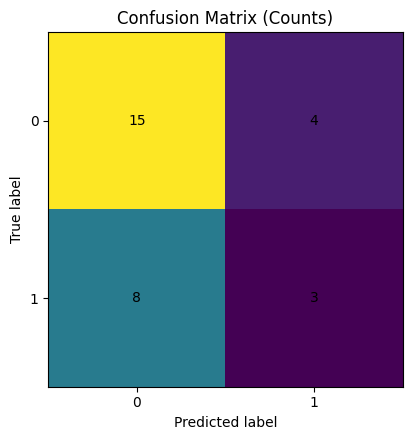

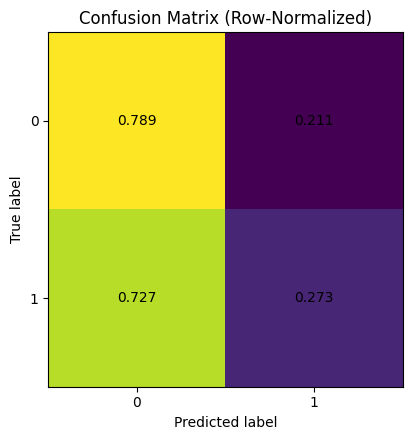

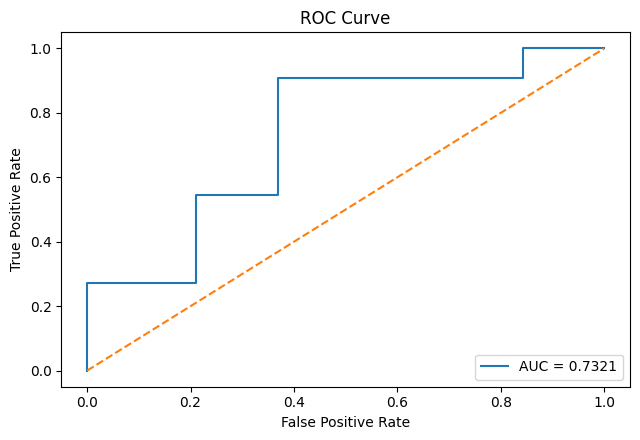

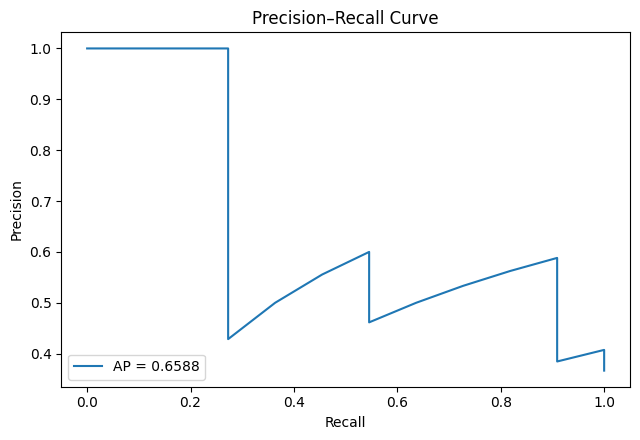


Threshold Tuning (Top Candidates by F1)


,threshold,precision,recall,f1
0,0.232571,0.555556,0.909091,0.689655
1,0.245125,0.562500,0.818182,0.666667
2,0.210686,0.526316,0.909091,0.666667
3,0.198509,0.476190,0.909091,0.625000
4,0.298385,0.533333,0.727273,0.615385
5,0.188308,0.454545,0.909091,0.606061
6,0.113722,0.407407,1.000000,0.578947
7,0.174083,0.416667,0.909091,0.571429
8,0.067171,0.392857,1.000000,0.564103
9,0.328272,0.500000,0.636364,0.560000



Top Feature Signals (Importance / Coefficients)


,coefficient
lcavol,0.852190
lbph,0.576327
lpsa,0.421884
lweight,-0.397492
lcp,-0.299878
gleason,-0.068273
age,0.052489
pgg45,0.003365


In [22]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix
)

# -----------------------------
# Regression panels
# -----------------------------
print("Regression — Model Comparison")

if all(v in globals() for v in ["X_train","X_test","y_train","y_test"]):

    from sklearn.linear_model import LinearRegression
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.tree import DecisionTreeRegressor

    # Use the same hyperparameters as the notebook sections
    lr = LinearRegression().fit(X_train, y_train)

    # Prefer scaled features if the notebook created them
    if "X_train_scaled" in globals() and "X_test_scaled" in globals():
        Xtr_knn, Xte_knn = X_train_scaled, X_test_scaled
    else:
        Xtr_knn, Xte_knn = X_train, X_test
    knn = KNeighborsRegressor(n_neighbors=10, metric="euclidean").fit(Xtr_knn, y_train)

    dt = DecisionTreeRegressor(max_depth=4, min_samples_split=20, random_state=123).fit(X_train, y_train)

    candidates = [
        ("LinearRegression", lr, X_train, X_test),
        ("KNNRegressor", knn, Xtr_knn, Xte_knn),
        ("DecisionTreeRegressor", dt, X_train, X_test),
    ]

    reg_rows = []
    for name, mdl, Xtr, Xte in candidates:
        yhat_tr = mdl.predict(Xtr)
        yhat_te = mdl.predict(Xte)
        reg_rows.append({
            "model": name,
            "train_MSE": float(mean_squared_error(y_train, yhat_tr)),
            "test_MSE": float(mean_squared_error(y_test, yhat_te)),
            "test_R2": float(r2_score(y_test, yhat_te)),
        })

    reg_table = pd.DataFrame(reg_rows).sort_values("test_MSE", ascending=True).reset_index(drop=True)
    display(reg_table)

    best_reg = reg_table.iloc[0].to_dict()
    print("\nRegression — Selected Best Model")
    for k, v in best_reg.items():
        if isinstance(v, float):
            print(f"- {k}: {v:.4f}")
        else:
            print(f"- {k}: {v}")

    # Optional: feature signal for tree if it wins, else show coefficients for LR
    print("\nTop Feature Signals (Regression)")
    if best_reg["model"] == "LinearRegression":
        coef = pd.Series(lr.coef_, index=list(X_train.columns)).sort_values(key=np.abs, ascending=False)
        display(coef.head(15).to_frame("coefficient"))
    elif best_reg["model"] == "DecisionTreeRegressor":
        imp = pd.Series(dt.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)
        display(imp.head(15).to_frame("importance"))
    else:
        print("No model-native coefficients/feature importances are available for the selected regression model.")
else:
    print("Regression panels could not be generated because required variables were not detected.")

print("\n" + "="*90 + "\n")

# -----------------------------
# Classification panels
# -----------------------------
print("Classification — Model Comparison")

if all(v in globals() for v in ["X_train2","X_test2","y_train2","y_test2"]):

    clf_candidates = []
    if "logit_model" in globals():
        clf_candidates.append(("LogisticRegression", logit_model, X_test2))
    if "knn_model" in globals() and "scaler2" in globals():
        clf_candidates.append(("KNNClassifier", knn_model, scaler2.transform(X_test2)))
    if "dtree_model" in globals():
        clf_candidates.append(("DecisionTreeClassifier", dtree_model, X_test2))

    rows = []
    for name, mdl, Xte in clf_candidates:
        yhat = mdl.predict(Xte)
        row = {
            "model": name,
            "accuracy": float(accuracy_score(y_test2, yhat)),
            "precision": float(precision_score(y_test2, yhat, zero_division=0)),
            "recall": float(recall_score(y_test2, yhat, zero_division=0)),
            "f1": float(f1_score(y_test2, yhat, zero_division=0)),
        }
        score = None
        if hasattr(mdl, "predict_proba"):
            score = mdl.predict_proba(Xte)[:, 1]
        elif hasattr(mdl, "decision_function"):
            score = mdl.decision_function(Xte)
        if score is not None:
            row["roc_auc"] = float(roc_auc_score(y_test2, score))
            row["pr_auc"] = float(average_precision_score(y_test2, score))
        rows.append(row)

    clf_table = pd.DataFrame(rows)
    sort_key = "roc_auc" if "roc_auc" in clf_table.columns else "f1"
    clf_table = clf_table.sort_values(sort_key, ascending=False).reset_index(drop=True)
    display(clf_table)

    best_row = clf_table.iloc[0].to_dict()
    best_name = best_row["model"]

    if best_name == "LogisticRegression":
        best_model = logit_model
        Xte_best = X_test2
    elif best_name == "KNNClassifier":
        best_model = knn_model
        Xte_best = scaler2.transform(X_test2)
    else:
        best_model = dtree_model
        Xte_best = X_test2

    y_pred_best = best_model.predict(Xte_best)

    print("\nClassification — Selected Best Model")
    for k, v in best_row.items():
        if isinstance(v, float):
            print(f"- {k}: {v:.4f}")
        else:
            print(f"- {k}: {v}")

    cm = confusion_matrix(y_test2, y_pred_best)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    print("\nConfusion Matrix (Counts)")
    display(pd.DataFrame(cm, index=["true_0","true_1"], columns=["pred_0","pred_1"]))

    print("\nConfusion Matrix (Row-Normalized)")
    display(pd.DataFrame(cm_norm, index=["true_0","true_1"], columns=["pred_0","pred_1"]))

    def _plot_cm(mat, title, fmt="d"):
        fig, ax = plt.subplots(figsize=(5.5, 4.5))
        ax.imshow(mat)
        ax.set_title(title)
        ax.set_xlabel("Predicted label")
        ax.set_ylabel("True label")
        ax.set_xticks([0,1]); ax.set_yticks([0,1])
        for (r, c), val in np.ndenumerate(mat):
            ax.text(c, r, (f"{int(val)}" if fmt=="d" else f"{val:.3f}"),
                    ha="center", va="center")
        fig.tight_layout()
        plt.show()

    _plot_cm(cm, "Confusion Matrix (Counts)", fmt="d")
    _plot_cm(cm_norm.astype(float), "Confusion Matrix (Row-Normalized)", fmt="f")

    score_vec = None
    if hasattr(best_model, "predict_proba"):
        score_vec = best_model.predict_proba(Xte_best)[:, 1]
    elif hasattr(best_model, "decision_function"):
        score_vec = best_model.decision_function(Xte_best)

    if score_vec is None:
        print("\nROC Curve / Precision–Recall Curve")
        print("No probability or decision score vector is available for the selected model; ROC/PR curves are omitted.")
        print("\nThreshold Tuning")
        print("No score/probability vector available; threshold tuning is omitted.")
    else:
        fpr, tpr, _ = roc_curve(y_test2, score_vec)
        roc_auc = roc_auc_score(y_test2, score_vec)

        fig, ax = plt.subplots(figsize=(6.5, 4.5))
        ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
        ax.plot([0,1], [0,1], linestyle="--")
        ax.set_title("ROC Curve")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend(loc="lower right")
        fig.tight_layout()
        plt.show()

        prec, rec, thr = precision_recall_curve(y_test2, score_vec)
        pr_auc = average_precision_score(y_test2, score_vec)

        fig, ax = plt.subplots(figsize=(6.5, 4.5))
        ax.plot(rec, prec, label=f"AP = {pr_auc:.4f}")
        ax.set_title("Precision–Recall Curve")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend(loc="lower left")
        fig.tight_layout()
        plt.show()

        thr = np.asarray(thr)
        if thr.size > 0:
            candidates = []
            for t in np.unique(np.quantile(thr, np.linspace(0.05, 0.95, 19))):
                yhat_t = (score_vec >= t).astype(int)
                candidates.append({
                    "threshold": float(t),
                    "precision": float(precision_score(y_test2, yhat_t, zero_division=0)),
                    "recall": float(recall_score(y_test2, yhat_t, zero_division=0)),
                    "f1": float(f1_score(y_test2, yhat_t, zero_division=0)),
                })
            thr_table = pd.DataFrame(candidates).sort_values("f1", ascending=False).head(10).reset_index(drop=True)
            print("\nThreshold Tuning (Top Candidates by F1)")
            display(thr_table)
        else:
            print("\nThreshold Tuning")
            print("Threshold table omitted because thresholds were not produced.")

    print("\nTop Feature Signals (Importance / Coefficients)")
    if hasattr(best_model, "coef_"):
        coef = pd.Series(best_model.coef_.ravel(), index=list(X_train2.columns)).sort_values(key=np.abs, ascending=False)
        display(coef.head(15).to_frame("coefficient"))
    elif hasattr(best_model, "feature_importances_"):
        imp = pd.Series(best_model.feature_importances_, index=list(X_train2.columns)).sort_values(ascending=False)
        display(imp.head(15).to_frame("importance"))
    else:
        print("No model-native importance or coefficients available for the selected model.")

else:
    print("Classification panels could not be generated because required variables were not detected.")
